In [ ]:
!py -m pip install pyvista --upgrade
!py -m pip install ipympl --upgrade
!py -m pip install trame --upgrade
!py -m pip install scipy --upgrade
!py -m pip install imageio --upgrade

In [1]:
import pyvista as pv
import numpy as np

import matplotlib.pyplot as plt
import imageio

from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy import optimize
from scipy.special import comb

from math import sqrt, cos, sin, pi, atan2, degrees

from shapely import affinity, distance
from shapely.geometry import Polygon, Point, LinearRing, LineString, MultiPoint
from shapely.plotting import plot_polygon, plot_points, plot_line
from shapely.ops import transform
from shapely.affinity import rotate

from tqdm.notebook import tqdm

In [122]:
def matan(point):
    angle = atan2(point.y, point.x)
    if angle <= 0: angle += 2*pi
    return angle

def norma(point):
    return Point(0,0).distance(point)

def Change(val1, val2):
    val1 = val1 + val2
    val2 = val1 - val2
    val1 = val1 - val2
    return val1, val2

In [317]:
def GetContourFromOBJ(filename):
    return LinearRing(MultiPoint(np.delete(pv.read(filename).project_points_to_plane().points, 2, 1)).convex_hull.boundary.coords)

def Contour2Points(contour, n):
    contour_pts = []
    for i in range(n):
        intersection = contour.intersection(LineString([(0,0), (20*cos((i/n)*2*pi), 20*sin((i/n)*2*pi))]))
        if intersection.geom_type == 'Point':
            contour_pts.append(intersection)
        else:
            contour_pts.append(intersection.geoms[-1])
    return contour_pts

def GetAngleOfRotation(contour_pts, pts, i1, i2):
    angle1, angle2 = matan(Point(pts.geoms[i1].x, pts.geoms[i1].y)), matan(Point(pts.geoms[i2].x, pts.geoms[i2].y))
    i_max, nrm_max = 0, norma(contour_pts[0])
    for i in range(1, len(contour_pts)):
        angle_cur = matan(contour_pts[i])
        if angle1 <= angle_cur and angle_cur <= angle2:
            nrm = norma(contour_pts[i])
            if nrm > nrm_max:
                nrm_max = nrm
                i_max = i
    return matan(contour_pts[i_max])

def RotateListOfPoints(contour_pts, angle):
    rotated_contour_pts = []
    for i in range(len(contour_pts)):
        rotated_contour_pts.append(rotate(contour_pts[i], angle, origin=Point(0.0,0.0), use_radians=True))
    return rotated_contour_pts

def TransformListOfPoints(contour_pts, x_trans, y_trans):
    transformed_contour_pts = []
    for i in range(len(contour_pts)):
        transformed_contour_pts.append(transform(lambda x, y, z=None: (x+(x_trans), y+(y_trans)), contour_pts[i]))
    return transformed_contour_pts

In [36]:
def GetEdgeIndices(rough_pts, pt_min, pt_max):
    angle_min, angle_max = matan(pt_min), matan(pt_max)
    for i in range(1, len(rough_pts)):
        if matan(rough_pts[i]) > angle_min:
            i_min = i
            break
    for i in range(1, len(rough_pts)):
        if matan(rough_pts[i]) > angle_max:
            i_max = i-1
            break
    return i_min, i_max

In [104]:
def GetPointOnLineWithDistance(line, distance):
    if distance < 0.0 or distance > line.length:
        return None
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return Point(coords[i][0], coords[i][1])
        if pd > distance:
           return line.interpolate(distance)
        
def GetCornerIndices(pts, threshold):
    al = []
    for i in range(len(pts)):
        al.append([pts[i].x, pts[i].y])

    a = np.array(al)
    dx_dt = np.gradient(a[:, 0])
    dy_dt = np.gradient(a[:, 1])
    velocity = np.array([ [dx_dt[i], dy_dt[i]] for i in range(dx_dt.size)])

    ds_dt = np.sqrt(dx_dt * dx_dt + dy_dt * dy_dt)

    tangent = np.array([1/ds_dt]).transpose() * velocity

    tangent_x = tangent[:, 0]
    tangent_y = tangent[:, 1]

    deriv_tangent_x = np.gradient(tangent_x)
    deriv_tangent_y = np.gradient(tangent_y)

    dT_dt = np.array([ [deriv_tangent_x[i], deriv_tangent_y[i]] for i in range(deriv_tangent_x.size)])

    length_dT_dt = np.sqrt(deriv_tangent_x * deriv_tangent_x + deriv_tangent_y * deriv_tangent_y)

    normal = np.array([1/length_dT_dt]).transpose() * dT_dt

    d2s_dt2 = np.gradient(ds_dt)
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)

    curvature = np.abs(d2x_dt2 * dy_dt - dx_dt * d2y_dt2) / (dx_dt * dx_dt + dy_dt * dy_dt)**1.5
    t_component = np.array([d2s_dt2] * 2).transpose()
    n_component = np.array([curvature * ds_dt * ds_dt] * 2).transpose()

    acceleration = t_component * tangent + n_component * normal

    # plt.plot(curvature)
    return [idx for idx, val in enumerate(curvature) if val>=threshold]

def GetBrutingTrace(rough_pts, target_pts, step, steps, threshold):
    alpha = step / steps
    bruting_rough_trace_pts = []
    if step%2 != 0:
        for i in range(len(rough_pts)):
            x1, y1 = rough_pts[i].x, rough_pts[i].y
            x2, y2 = target_pts[i].x, target_pts[i].y
            bruting_rough_trace_pts.append(Point((1-alpha)*x1+alpha*x2, (1-alpha)*y1+alpha*y2))
    else:
        for i in reversed(range(len(rough_pts))):
            x1, y1 = rough_pts[i].x, rough_pts[i].y
            x2, y2 = target_pts[i].x, target_pts[i].y
            bruting_rough_trace_pts.append(Point((1-alpha)*x1+alpha*x2, (1-alpha)*y1+alpha*y2))
    
    bruting_trace_pts = bruting_rough_trace_pts
    
    # mean = GetAverageCurvature(bruting_rough_trace_pts)
    indices = GetCornerIndices(bruting_rough_trace_pts, threshold)

    while len(indices) != 0:
        # print(len(indices))
        bruting_trace_pts = []
        for i in range(len(bruting_rough_trace_pts)):
            if i not in indices:
                bruting_trace_pts.append(bruting_rough_trace_pts[i])
            else:
                pt1 = bruting_rough_trace_pts[i-1]
                pt2 = bruting_rough_trace_pts[i+1]
                pt = bruting_rough_trace_pts[i]
                nrm = norma(pt)
                coeff = (norma(pt1)+norma(pt2))/2
                bruting_trace_pts.append(Point(coeff*pt.x/nrm, coeff*pt.y/nrm))

        bruting_rough_trace_pts = bruting_trace_pts
        # mean = GetAverageCurvature(bruting_rough_trace_pts)
        indices = GetCornerIndices(bruting_rough_trace_pts, threshold)

    print("Smoothing done")
    
    delta_len = LineString(bruting_trace_pts).length/(len(rough_pts)-1)
    # line = LineString(bruting_trace_pts).segmentize(max_segment_length=delta_len)
    line = LineString(bruting_trace_pts)

    # bruting_trace_pts = []
    # for i in tqdm(range(len(rough_pts))):
    #     bruting_trace_pts.append(GetPointOnLineWithDistance(line, i*delta_len))

    return bruting_trace_pts

def GetParallelOffset(bruting_trace_pts, j, R):
    normal_vectors = []
    for i in range(len(bruting_trace_pts)-1):
        pt1, pt2 = bruting_trace_pts[i], bruting_trace_pts[i+1]
        x1, y1 = pt1.x, pt1.y
        x2, y2 = pt2.x, pt2.y
        nrm = sqrt((x2-x1)**2+(y2-y1)**2)
        if j%2 != 0:
            normal_vectors.append(Point(R*(y2-y1)/nrm, -R*(x2-x1)/nrm))
        else:
            normal_vectors.append(Point(-R*(y2-y1)/nrm, R*(x2-x1)/nrm))
    
    normal_vertices = []
    normal_vertices.append(normal_vectors[0])
    for i in range(len(normal_vectors)-1):
        x = (normal_vectors[i].x+normal_vectors[i+1].x)/2
        y = (normal_vectors[i].y+normal_vectors[i+1].y)/2
        normal_vertices.append(Point(x, y))
    normal_vertices.append(normal_vectors[-1])

    disk_trace_pts = []
    for i in range(len(bruting_trace_pts)):
        x = bruting_trace_pts[i].x+normal_vertices[i].x
        y = bruting_trace_pts[i].y+normal_vertices[i].y
        disk_trace_pts.append(Point(x, y))

    # return list(MultiPoint(LineString(bruting_trace_pts).parallel_offset(R, 'right', join_style=1).coords).geoms)
    return disk_trace_pts

# def GetParallelOffset(bruting_trace_pts, j, R):
#     nrms = GetNormalVectors(bruting_trace_pts)
#     print(nrms)


def GetReversed(pts):
    reversed_pts = []
    for i in reversed(range(len(pts))):
        reversed_pts.append(pts[i])
    return reversed_pts

def CreateDisk(R):
    disk_pts = []
    for i in range(1000):
        angle = (i/1000)*2*pi
        disk_pts.append(Point(R*cos(angle), R*sin(angle)))
    return disk_pts

In [325]:
def GetTrace(whole_rough_pts, i_edge_min, i_edge_max, rough_pts, target_pts, disk_trace_pts, disk, R, j, k):
    if j%2 == 0:
        rough_string = LinearRing(rough_pts)
        npts = rough_string.intersection(disk)
        opts = rough_string.intersection(LineString(target_pts))

        if opts.geom_type == "MultiPoint":
            reper_angle1 = matan(opts.geoms[0])
            reper_angle2 = matan(opts.geoms[1])
        else:
            pt1 = Point(opts.geoms[0].coords[1][0], opts.geoms[0].coords[1][1])
            pt2 =  Point(opts.geoms[1].coords[0][0], opts.geoms[1].coords[0][1])
            spatial_len = pt1.distance(pt2)
            for i in range(len(opts.geoms)-1):
                pt1 = Point(opts.geoms[i].coords[1][0], opts.geoms[i].coords[1][1])
                pt2 =  Point(opts.geoms[i+1].coords[0][0], opts.geoms[i+1].coords[0][1])
                if pt1.distance(pt2) > 10*spatial_len:
                    i_reper = i
                    break

            reper_angle1 = atan2(opts.geoms[i_reper].coords[0][1], opts.geoms[i_reper].coords[0][0])
            reper_angle2 = atan2(opts.geoms[i_reper+1].coords[1][1], opts.geoms[i_reper+1].coords[1][0])
            if reper_angle1 <= 0: reper_angle1 += 2*pi
            if reper_angle2 <= 0: reper_angle2 += 2*pi

        anglec = matan(disk_trace_pts[k])
        rc = norma(disk_trace_pts[k])

        trace = []
        if npts.geom_type == 'LineString':
            if len(npts.coords) != 0:
                angle_edge = atan2(npts.coords[-1][1], npts.coords[-1][0])
                if angle_edge <= 0:
                    angle_edge += 2*pi

                for i in range(len(rough_pts)):
                    if matan(rough_pts[i]) >= angle_edge:
                        i_intersect = i
                        break

                for i in (range(len(rough_pts))):
                    if i < k:
                        trace.append(target_pts[i])
                    elif k <= i and i < i_intersect:
                        angle_cur = matan(rough_pts[i])

                        # if angle_cur > angle_edge:
                        #     angle_cur -= 1e-3
                        
                        lr = rc*cos(angle_cur-anglec)-sqrt(R**2-(rc*sin(angle_cur-anglec))**2)
                        trace.append(Point(lr*cos(angle_cur), lr*sin(angle_cur)))
                    else:
                        trace.append(rough_pts[i])
            else:
                angle_c = matan(target_pts[k])

                if rough_string.distance(disk.centroid) > R:
                    if angle_c < reper_angle1:
                        for i in (range(len(rough_pts))):
                            trace.append(rough_pts[i])
                    if reper_angle2 <= angle_c:
                        for i in range(len(target_pts)):
                            if matan(target_pts[i]) >= reper_angle1:
                                i_intersect1 = i
                                break
                        for i in range(len(target_pts)):
                            if matan(target_pts[i]) >= reper_angle2:
                                i_intersect2 = i
                                break
                        for i in range(len(rough_pts)):
                            if i < i_intersect1:
                                trace.append(rough_pts[i])
                            elif i_intersect1 <= i and i < i_intersect2:
                                trace.append(target_pts[i])
                            else:
                                trace.append(rough_pts[i])
                else:
                    for i in (range(len(rough_pts))):
                        if i < k:
                            trace.append(target_pts[i])
                        else:
                            trace.append(rough_pts[i])
        else:
            if len(npts.geoms[0].coords) != 0:

                angle_edge = atan2(npts.geoms[0].coords[-1][1], npts.geoms[0].coords[-1][0])
                if angle_edge <= 0:
                    angle_edge += 2*pi

                for i in range(len(rough_pts)):
                    if matan(rough_pts[i]) >= angle_edge:
                        i_intersect = i
                        break

                for i in (range(len(rough_pts))):
                    if i < k:
                        trace.append(target_pts[i])
                    elif k <= i and i < i_intersect:
                        angle_cur = matan(rough_pts[i])

                        # if angle_cur > angle_edge:
                        #     angle_cur -= 1e-3
                            
                        lr = rc*cos(angle_cur-anglec)-sqrt(R**2-(rc*sin(angle_cur-anglec))**2)
                        trace.append(Point(lr*cos(angle_cur), lr*sin(angle_cur)))
                    else:
                        trace.append(rough_pts[i])
            else:
                angle_c = matan(target_pts[k])

                if rough_string.distance(disk.centroid) > R:
                    if angle_c < reper_angle1:
                        for i in (range(len(rough_pts))):
                            trace.append(rough_pts[i])
                    if reper_angle2 <= angle_c:
                        for i in range(len(target_pts)):
                            if matan(target_pts[i]) >= reper_angle1:
                                i_intersect1 = i
                                break
                        for i in range(len(target_pts)):
                            if matan(target_pts[i]) >= reper_angle2:
                                i_intersect2 = i
                                break
                        for i in range(len(rough_pts)):
                            if i < i_intersect1:
                                trace.append(rough_pts[i])
                            elif i_intersect1 <= i and i < i_intersect2:
                                trace.append(target_pts[i])
                            else:
                                trace.append(rough_pts[i])
                else:
                    for i in (range(len(rough_pts))):
                        if i < k:
                            trace.append(target_pts[i])
                        else:
                            trace.append(rough_pts[i])
    else:
        rough_string = LinearRing(rough_pts)
        npts = rough_string.intersection(disk)
        opts = rough_string.intersection(LineString(target_pts))

        if opts.geom_type == "MultiPoint":
            reper_angle1 = matan(opts.geoms[0])
            reper_angle2 = matan(opts.geoms[1])
        else:
            pt1 = Point(opts.geoms[0].coords[1][0], opts.geoms[0].coords[1][1])
            pt2 =  Point(opts.geoms[1].coords[0][0], opts.geoms[1].coords[0][1])
            spatial_len = pt1.distance(pt2)
            for i in range(len(opts.geoms)-1):
                pt1 = Point(opts.geoms[i].coords[1][0], opts.geoms[i].coords[1][1])
                pt2 =  Point(opts.geoms[i+1].coords[0][0], opts.geoms[i+1].coords[0][1])
                if pt1.distance(pt2) > 10*spatial_len:
                    i_reper = i
                    break

            reper_angle1 = atan2(opts.geoms[i_reper].coords[0][1], opts.geoms[i_reper].coords[0][0])
            reper_angle2 = atan2(opts.geoms[i_reper+1].coords[1][1], opts.geoms[i_reper+1].coords[1][0])
            if reper_angle1 <= 0: reper_angle1 += 2*pi
            if reper_angle2 <= 0: reper_angle2 += 2*pi

            if reper_angle1 < reper_angle2:
                val = reper_angle1
                reper_angle1 = reper_angle2
                reper_angle2 = val

        anglec = matan(disk_trace_pts[k])
        rc = norma(disk_trace_pts[k])

        trace = []
        if npts.geom_type == 'LineString':
            if len(npts.coords) != 0:
                angle_edge = atan2(npts.coords[-1][1], npts.coords[-1][0])
                if angle_edge <= 0:
                    angle_edge += 2*pi

                for i in range(len(rough_pts)):
                    if matan(rough_pts[i]) <= angle_edge:
                        i_intersect = i
                        break

                for i in (range(len(rough_pts))):
                    if i < k:
                        trace.append(target_pts[i])
                    elif k <= i and i < i_intersect:
                        angle_cur = matan(rough_pts[i])

                        # if angle_cur < angle_edge:
                        #     angle_cur += 1e-3
                        
                        lr = rc*cos(angle_cur-anglec)-sqrt(R**2-(rc*sin(angle_cur-anglec))**2)
                        trace.append(Point(lr*cos(angle_cur), lr*sin(angle_cur)))
                    else:
                        trace.append(rough_pts[i])
            else:
                angle_c = matan(target_pts[k])

                if rough_string.distance(disk.centroid) > R:
                    if angle_c > reper_angle2:
                        for i in (range(len(rough_pts))):
                            trace.append(rough_pts[i])
                    if angle_c <= reper_angle1:
                        for i in range(len(target_pts)):
                            if matan(target_pts[i]) <= reper_angle1:
                                i_intersect1 = i
                                break
                        for i in range(len(target_pts)):
                            if matan(target_pts[i]) <= reper_angle2:
                                i_intersect2 = i
                                break
                        for i in range(len(rough_pts)):
                            if i < i_intersect1:
                                trace.append(rough_pts[i])
                            elif i_intersect1 <= i and i < i_intersect2:
                                trace.append(target_pts[i])
                            else:
                                trace.append(rough_pts[i])
                else:
                    for i in (range(len(rough_pts))):
                        if i < k:
                            trace.append(target_pts[i])
                        else:
                            trace.append(rough_pts[i])
        else:
            if len(npts.geoms[0].coords) != 0:
                angle_edge = atan2(npts.geoms[0].coords[-1][1], npts.geoms[0].coords[-1][0])
                if angle_edge <= 0:
                    angle_edge += 2*pi

                for i in range(len(rough_pts)):
                    if matan(rough_pts[i]) <= angle_edge:
                        i_intersect = i
                        break

                for i in (range(len(rough_pts))):
                    if i < k:
                        trace.append(target_pts[i])
                    elif k <= i and i < i_intersect:
                        angle_cur = matan(rough_pts[i])

                        # if angle_cur < angle_edge:
                        #     angle_cur += 1e-3
                            
                        lr = rc*cos(angle_cur-anglec)-sqrt(R**2-(rc*sin(angle_cur-anglec))**2)
                        trace.append(Point(lr*cos(angle_cur), lr*sin(angle_cur)))
                    else:
                        trace.append(rough_pts[i])
            else:
                angle_c = matan(target_pts[k])

                if rough_string.distance(disk.centroid) > R:
                    if angle_c > reper_angle2:
                        for i in (range(len(rough_pts))):
                            trace.append(rough_pts[i])
                    if angle_c <= reper_angle1:
                        for i in range(len(target_pts)):
                            if matan(target_pts[i]) <= reper_angle1:
                                i_intersect1 = i
                                break
                        for i in range(len(target_pts)):
                            if matan(target_pts[i]) <= reper_angle2:
                                i_intersect2 = i
                                break
                        for i in range(len(rough_pts)):
                            if i < i_intersect1:
                                trace.append(rough_pts[i])
                            elif i_intersect1 <= i and i < i_intersect2:
                                trace.append(target_pts[i])
                            else:
                                trace.append(rough_pts[i])
                else:
                    for i in (range(len(rough_pts))):
                        if i < k:
                            trace.append(target_pts[i])
                        else:
                            trace.append(rough_pts[i])
    
    bruting_trace = []
    for i in range(len(whole_rough_pts)):
        if i <= i_edge_min:
            bruting_trace.append(whole_rough_pts[i])
        elif i >= i_edge_max:
            bruting_trace.append(whole_rough_pts[i])
        else:
            bruting_trace.append(trace[i-i_edge_min])
        
    return bruting_trace

In [359]:
R = 1
n = 10000
i1, i2 = 1, 7
baloon_distance = 0.3

rough   = GetContourFromOBJ("data\\B4969-B_PLANNING_pear\\rough.obj")
pear    = GetContourFromOBJ("data\\B4969-B_PLANNING_pear\\diamond.obj")

baloon_pear = LinearRing(LineString(pear).parallel_offset(baloon_distance, 'left', join_style=2))

rough_pts       = Contour2Points(rough, n)
pear_pts        = Contour2Points(pear, n)
baloon_pear_pts = Contour2Points(baloon_pear, n)

intersection_pts = rough.intersection(baloon_pear)

i_edge_min, i_edge_max = GetEdgeIndices(rough_pts, intersection_pts.geoms[i1], intersection_pts.geoms[i2])
if i_edge_min > i_edge_max: i_edge_min, i_edge_max = Change(i_edge_min, i_edge_max)
print(i_edge_min, i_edge_max)

rotation_angle = GetAngleOfRotation(rough_pts, intersection_pts, i1, i2)
rotation_angle = matan(intersection_pts.geoms[i1])

pt_min = rotate(intersection_pts.geoms[i1], -rotation_angle, origin=Point(0.0,0.0), use_radians=True)
pt_max = rotate(intersection_pts.geoms[i2], -rotation_angle, origin=Point(0.0,0.0), use_radians=True)

rough_rotated_pts       = RotateListOfPoints(rough_pts, -rotation_angle)
pear_rotated_pts        = RotateListOfPoints(pear_pts,  -rotation_angle)
baloon_pear_rotated_pts = RotateListOfPoints(baloon_pear_pts, -rotation_angle)

# plot_points(rough_rotated_pts, color=(0,0,1), markersize=1, label="rough pear")
# plot_points(pear_rotated_pts, color=(1,0,0), markersize=1, label="target pear")
# plot_points(baloon_pear_rotated_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
# plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")
# plot_points(rough_rotated_pts[i_edge_min], color=(0,0,0), markersize=5, label="min")
# plot_points(rough_rotated_pts[i_edge_max], color=(0,0,0), markersize=5, label="max")

5192 7105


In [360]:
steps = 3

threshold = 10

trace = GetBrutingTrace(rough_rotated_pts[i_edge_min:i_edge_max], baloon_pear_rotated_pts[i_edge_min:i_edge_max], 1, steps, threshold)

bruting_traces = []
disk_traces = []

bruting_traces.append(GetBrutingTrace(rough_rotated_pts[i_edge_min:i_edge_max], baloon_pear_rotated_pts[i_edge_min:i_edge_max], 1, steps, threshold))
disk_traces.append(GetParallelOffset(bruting_traces[-1], 1, R))

for j in range(2, steps+1):
    bruting_traces.append(GetBrutingTrace(bruting_traces[-1], baloon_pear_rotated_pts[i_edge_min:i_edge_max], j, steps, threshold))
    disk_traces.append(GetParallelOffset(bruting_traces[-1], j, R))

pear_rotated = LineString(pear_rotated_pts)
balooned_pear_rotated = LineString(baloon_pear_rotated_pts)
bruting_traces_plgs = []
for j in range(len(bruting_traces)):
    bruting_traces_plgs.append(LineString(bruting_traces[j]))

Smoothing done
Smoothing done
Smoothing done
Smoothing done


In [ ]:
# plot_points(rough_rotated_pts, color=(0,0,1), markersize=1, label="rough pear")
plot_points(pear_rotated_pts, color=(1,0,0), markersize=1, label="target pear")
plot_points(baloon_pear_rotated_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")
# plot_points(rough_rotated_pts[i_edge_min], color=(0,0,0), markersize=5, label="min")
# plot_points(rough_rotated_pts[i_edge_max], color=(0,0,0), markersize=5, label="max")

j = steps-1
# k = 500
k = i_edge_max-i_edge_min-1

plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

disk_pts = CreateDisk(R)
disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(disk_pts))
plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4)

plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")

current_rough_pts = rough_rotated_pts[i_edge_min:i_edge_max] if j == 0 else GetReversed(bruting_traces[j-1])
rough_trace = GetTrace(rough_rotated_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
plot_points(rough_trace, color=(0,0,1), markersize=1, label="rough pear")

plt.rcParams["figure.figsize"] = (8.0, 8.0)
# plt.xlim(-0.3, 4.0)
# plt.ylim(-0.5, 3.0)
plt.legend()

In [ ]:
delta = 0.4
r = 2

j = 1
i = 0
k = 0
# k = i_edge_max-i_edge_min-1
angle = matan(disk_traces[j][k])

xstep = (k/n)*delta*6
xval = R+r-affinity.rotate(disk_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True).x-xstep

plot_points(Point(0.0, 0.0), color=(0,0,0), alpha=0.7, label="absolute center")

plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(pear_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(1,0,0), markersize=0.5, label="target pear")
plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(balooned_pear_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(0.5,0.2,0), markersize=0.5, label="balooned pear")
plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces_plgs[j], -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(0,1,0), markersize=0.5, label="bruting trace")

disk_pts = CreateDisk(R)
disk = transform(lambda x, y, z=None: (x+R+r-xstep, y), Polygon(disk_pts))
plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4, label="bruting disk")

plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(0,1,0), alpha=0.7, label="touch point")

current_rough_pts = rough_rotated_pts[i_edge_min:i_edge_max] if j == 0 else GetReversed(bruting_traces[j-1])

disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(disk_pts))
rough_trace = GetTrace(rough_rotated_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
rotated_rough_trace = RotateListOfPoints(rough_trace, -angle)
transformed_rotated_rough_trace = TransformListOfPoints(rotated_rough_trace, xval, 0)
plot_points(transformed_rotated_rough_trace, color=(0,0,1), markersize=0.5, label="rough pear")

plt.rcParams["figure.figsize"] = (8.0,8.0)
plt.xlim(-6.5, 4)
plt.ylim(-6, 3)
plt.legend()

In [110]:
delta = 0.5
r = 2

path = "swing/general/test1/"

i = 0
for j in range(0, steps):
        for k in tqdm(range(0, i_edge_max-i_edge_min, 20)):
                angle = matan(disk_traces[j][k])

                xstep = (k/n)*delta*6
                xval = R+r-affinity.rotate(disk_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True).x-xstep

                plot_points(Point(0.0, 0.0), color=(0,0,0), alpha=0.7, label="absolute center")

                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(pear_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(1,0,0), markersize=0.5, label="target pear")
                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(balooned_pear_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(0.5,0.2,0), markersize=0.5, label="balooned pear")
                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces_plgs[j], -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(0,1,0), markersize=0.5, label="bruting trace")

                disk_pts = CreateDisk(R)
                disk = transform(lambda x, y, z=None: (x+R+r-xstep, y), Polygon(disk_pts))
                plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4, label="bruting disk")

                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(0,1,0), alpha=0.7, label="touch point")

                current_rough_pts = rough_rotated_pts[i_edge_min:i_edge_max] if j == 0 else GetReversed(bruting_traces[j-1])

                disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(disk_pts))
                rough_trace = GetTrace(rough_rotated_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
                rotated_rough_trace = RotateListOfPoints(rough_trace, -angle)
                transformed_rotated_rough_trace = TransformListOfPoints(rotated_rough_trace, xval, 0)
                plot_points(transformed_rotated_rough_trace, color=(0,0,1), markersize=0.5, label="rough pear")

                plt.rcParams["figure.figsize"] = (8.0,8.0)
                plt.xlim(-6.5, 4)
                plt.ylim(-6, 3)
                plt.legend()
                plt.savefig(path+"pics/" + str(i) + ".png")
                plt.close()
                i += 1

with imageio.get_writer(path+'movie.gif', mode='I', duration=0.01) as writer:
    for j in range(i):
        writer.append_data(imageio.imread(path+"pics/" + str(j) + ".png"))

C:\Users\konov\AppData\Local\Temp\ipykernel_16220\3723245843.py:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(path+"pics/" + str(j) + ".png"))


In [ ]:
# rough_rotated_pts

j = steps-1
k = i_edge_max-i_edge_min-1
disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))
current_rough_pts = rough_rotated_pts[i_edge_min:i_edge_max] if j == 0 else GetReversed(bruting_traces[j-1])
rough_trace = GetTrace(rough_rotated_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)

rough_rotated_pts = rough_trace

plot_points(pear_rotated_pts, color=(1,0,0), markersize=1, label="target pear")
plot_points(baloon_pear_rotated_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
plot_points(rough_rotated_pts, color=(0,0,1), markersize=1, label="rough pear")
plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

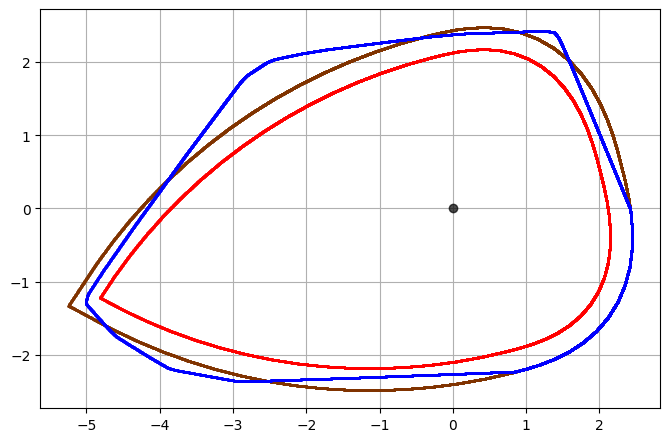

In [361]:
# rough_rotated_pts

j = steps-1
k = i_edge_max-i_edge_min-1
disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))
current_rough_pts = rough_rotated_pts[i_edge_min:i_edge_max] if j == 0 else GetReversed(bruting_traces[j-1])
rough_trace = GetTrace(rough_rotated_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)

rough_rotated_pts = rough_trace

rotation_angle = matan(intersection_pts.geoms[i2])-matan(intersection_pts.geoms[i1])

rough_rotated_pts       = RotateListOfPoints(rough_rotated_pts, -rotation_angle)
pear_rotated_pts        = RotateListOfPoints(pear_rotated_pts,  -rotation_angle)
baloon_pear_rotated_pts = RotateListOfPoints(baloon_pear_rotated_pts, -rotation_angle)

plot_points(pear_rotated_pts, color=(1,0,0), markersize=1, label="target pear")
plot_points(baloon_pear_rotated_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
plot_points(rough_rotated_pts, color=(0,0,1), markersize=1, label="rough pear")
plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

GEOMETRYCOLLECTION (LINESTRING (0.8609214219657432 -2.224864726979125, 0.8623797352432266 -2.22447956634397), LINESTRING (0.8623797352432266 -2.22447956634397, 0.8638382539418884 -2.224094351454251), LINESTRING (0.8638382539418884 -2.224094351454251, 0.8652969792569778 -2.2237090819942855), LINESTRING (0.8652969792569778 -2.2237090819942855, 0.8667559123844146 -2.2233237576482154), LINESTRING (0.8667559123844146 -2.2233237576482154, 0.8682150545207808 -2.222938378100006), LINESTRING (0.8682150545207808 -2.222938378100006, 0.8696744068633354 -2.222552943033446), LINESTRING (0.8696744068633354 -2.222552943033446, 0.8711339706100152 -2.222167452132142), LINESTRING (0.8711339706100152 -2.222167452132142, 0.8725937469594349 -2.2217819050795247), LINESTRING (0.8725937469594349 -2.2217819050795247, 0.874053737110898 -2.2213963015588414), LINESTRING (0.874053737110898 -2.2213963015588414, 0.8755139422643924 -2.2210106412531583), LINESTRING (0.8755139422643924 -2.2210106412531583, 0.87697436362

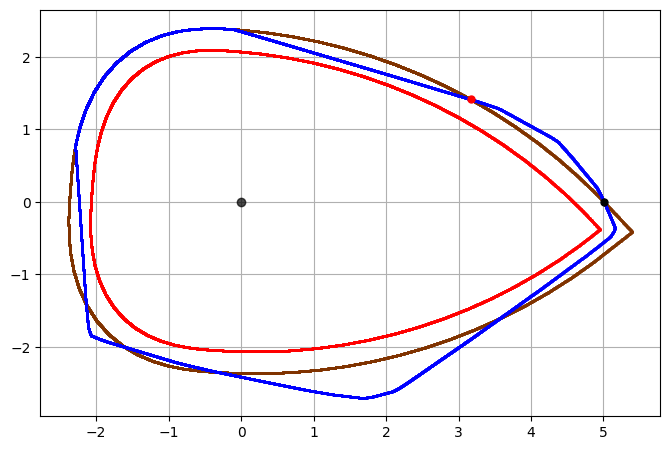

In [362]:
i1, i2 = 0, 2

rough_pts       = rough_rotated_pts
pear_pts        = pear_rotated_pts
baloon_pear_pts = baloon_pear_rotated_pts

intersection = LineString(rough_pts).intersection(LineString(baloon_pear_pts))
print(intersection)
intersection_pts = []
for item in intersection.geoms:
    if item.geom_type == "Point":
        intersection_pts.append(item)
intersection_pts = MultiPoint(intersection_pts)

i_edge_min, i_edge_max = GetEdgeIndices(rough_pts, intersection_pts.geoms[i1], intersection_pts.geoms[i2])
if i_edge_min > i_edge_max: i_edge_min, i_edge_max = Change(i_edge_min, i_edge_max)
print(i_edge_min, i_edge_max)

# plot_points(pear_pts, color=(1,0,0), markersize=1, label="target pear")
# plot_points(baloon_pear_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
# plot_points(rough_pts, color=(0,0,1), markersize=1, label="rough pear")
# plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")
# # plot_points(rough_rotated_pts[i_edge_min], color=(0,0,0), markersize=5, label="min")
# # plot_points(rough_rotated_pts[i_edge_max], color=(0,0,0), markersize=5, label="max")
# plot_points(intersection_pts.geoms[i1], color=(0,0,0), markersize=5, label="min")
# plot_points(intersection_pts.geoms[i2], color=(1,0,0), markersize=5, label="max")

rotation_angle = GetAngleOfRotation(rough_pts, intersection_pts, i1, i2)
rotation_angle = matan(intersection_pts.geoms[i1])

pt_min = rotate(intersection_pts.geoms[i1], -rotation_angle, origin=Point(0.0,0.0), use_radians=True)
pt_max = rotate(intersection_pts.geoms[i2], -rotation_angle, origin=Point(0.0,0.0), use_radians=True)

rough_rotated_pts       = RotateListOfPoints(rough_pts, -rotation_angle)
pear_rotated_pts        = RotateListOfPoints(pear_pts,  -rotation_angle)
baloon_pear_rotated_pts = RotateListOfPoints(baloon_pear_pts, -rotation_angle)

plot_points(pear_rotated_pts, color=(1,0,0), markersize=1, label="target pear")
plot_points(baloon_pear_rotated_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
plot_points(rough_rotated_pts, color=(0,0,1), markersize=1, label="rough pear")
plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")
# plot_points(rough_rotated_pts[i_edge_min], color=(0,0,0), markersize=5, label="min")
# plot_points(rough_rotated_pts[i_edge_max], color=(0,0,0), markersize=5, label="max")
plot_points(pt_min, color=(0,0,0), markersize=5, label="min")
plot_points(pt_max, color=(1,0,0), markersize=5, label="max")

In [357]:
steps = 1

threshold = 10

trace = GetBrutingTrace(rough_rotated_pts[i_edge_min:i_edge_max], baloon_pear_rotated_pts[i_edge_min:i_edge_max], 1, steps, threshold)

bruting_traces = []
disk_traces = []

bruting_traces.append(GetBrutingTrace(rough_rotated_pts[i_edge_min:i_edge_max], baloon_pear_rotated_pts[i_edge_min:i_edge_max], 1, steps, threshold))
disk_traces.append(GetParallelOffset(bruting_traces[-1], 1, R))

for j in range(2, steps+1):
    bruting_traces.append(GetBrutingTrace(bruting_traces[-1], baloon_pear_rotated_pts[i_edge_min:i_edge_max], j, steps, threshold))
    disk_traces.append(GetParallelOffset(bruting_traces[-1], j, R))

pear_rotated = LineString(pear_rotated_pts)
balooned_pear_rotated = LineString(baloon_pear_rotated_pts)
bruting_traces_plgs = []
for j in range(len(bruting_traces)):
    bruting_traces_plgs.append(LineString(bruting_traces[j]))

Smoothing done
Smoothing done


In [ ]:
# plot_points(rough_rotated_pts, color=(0,0,1), markersize=1, label="rough pear")
plot_points(pear_rotated_pts, color=(1,0,0), markersize=1, label="target pear")
plot_points(baloon_pear_rotated_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")
# plot_points(rough_rotated_pts[i_edge_min], color=(0,0,0), markersize=5, label="min")
# plot_points(rough_rotated_pts[i_edge_max], color=(0,0,0), markersize=5, label="max")

j = steps-1
# k = 500
k = i_edge_max-i_edge_min-1

plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

disk_pts = CreateDisk(R)
disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(disk_pts))
plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4)

plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")

current_rough_pts = rough_rotated_pts[i_edge_min:i_edge_max] if j == 0 else GetReversed(bruting_traces[j-1])
rough_trace = GetTrace(rough_rotated_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
plot_points(rough_trace, color=(0,0,1), markersize=1, label="rough pear")

plt.rcParams["figure.figsize"] = (8.0, 8.0)
# plt.xlim(-0.3, 4.0)
# plt.ylim(-0.5, 3.0)
plt.legend()

In [ ]:
# plot_points(rough_rotated_pts, color=(0,0,1), markersize=1, label="rough pear")
plot_points(pear_rotated_pts, color=(1,0,0), markersize=1, label="target pear")
plot_points(baloon_pear_rotated_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")
# plot_points(rough_rotated_pts[i_edge_min], color=(0,0,0), markersize=5, label="min")
# plot_points(rough_rotated_pts[i_edge_max], color=(0,0,0), markersize=5, label="max")

j = steps-1
# k = 500
k = i_edge_max-i_edge_min-1

plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

disk_pts = CreateDisk(R)
disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(disk_pts))
plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4)

plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")

current_rough_pts = rough_rotated_pts[i_edge_min:i_edge_max] if j == 0 else GetReversed(bruting_traces[j-1])
rough_trace = GetTrace(rough_rotated_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
plot_points(rough_trace, color=(0,0,1), markersize=1, label="rough pear")

plt.rcParams["figure.figsize"] = (8.0, 8.0)
# plt.xlim(-0.3, 4.0)
# plt.ylim(-0.5, 3.0)
plt.legend()

In [ ]:
# plot_points(rough_rotated_pts, color=(0,0,1), markersize=1, label="rough pear")
plot_points(pear_rotated_pts, color=(1,0,0), markersize=1, label="target pear")
plot_points(baloon_pear_rotated_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")
# plot_points(rough_rotated_pts[i_edge_min], color=(0,0,0), markersize=5, label="min")
# plot_points(rough_rotated_pts[i_edge_max], color=(0,0,0), markersize=5, label="max")

j = steps-1
# k = 500
k = i_edge_max-i_edge_min-1

plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

disk_pts = CreateDisk(R)
disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(disk_pts))
plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4)

plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")

current_rough_pts = rough_rotated_pts[i_edge_min:i_edge_max] if j == 0 else GetReversed(bruting_traces[j-1])
rough_trace = GetTrace(rough_rotated_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
plot_points(rough_trace, color=(0,0,1), markersize=1, label="rough pear")

plt.rcParams["figure.figsize"] = (8.0, 8.0)
# plt.xlim(-0.3, 4.0)
# plt.ylim(-0.5, 3.0)
plt.legend()

In [ ]:
delta = 0.4
r = 2

j = steps-1
i = 0
k = 0
k = i_edge_max-i_edge_min-1
angle = matan(disk_traces[j][k])

xstep = (k/n)*delta*6
xval = R+r-affinity.rotate(disk_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True).x-xstep

plot_points(Point(0.0, 0.0), color=(0,0,0), alpha=0.7, label="absolute center")

plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(pear_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(1,0,0), markersize=0.5, label="target pear")
plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(balooned_pear_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(0.5,0.2,0), markersize=0.5, label="balooned pear")
plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces_plgs[j], -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(0,1,0), markersize=0.5, label="bruting trace")

disk_pts = CreateDisk(R)
disk = transform(lambda x, y, z=None: (x+R+r-xstep, y), Polygon(disk_pts))
plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4, label="bruting disk")

plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(0,1,0), alpha=0.7, label="touch point")

current_rough_pts = rough_rotated_pts[i_edge_min:i_edge_max] if j == 0 else GetReversed(bruting_traces[j-1])

disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(disk_pts))
rough_trace = GetTrace(rough_rotated_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
rotated_rough_trace = RotateListOfPoints(rough_trace, -angle)
transformed_rotated_rough_trace = TransformListOfPoints(rotated_rough_trace, xval, 0)
plot_points(transformed_rotated_rough_trace, color=(0,0,1), markersize=0.5, label="rough pear")

plt.rcParams["figure.figsize"] = (8.0,8.0)
plt.xlim(-6.5, 4)
plt.ylim(-6, 6)
plt.legend()

In [ ]:
delta = 0.5
r = 2

path = "swing/general/test3/"

i = 0
for j in range(0, steps):
        for k in tqdm(range(0, i_edge_max-i_edge_min, 20)):
                angle = matan(disk_traces[j][k])

                xstep = (k/n)*delta*6
                xval = R+r-affinity.rotate(disk_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True).x-xstep

                plot_points(Point(0.0, 0.0), color=(0,0,0), alpha=0.7, label="absolute center")

                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(pear_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(1,0,0), markersize=0.5, label="target pear")
                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(balooned_pear_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(0.5,0.2,0), markersize=0.5, label="balooned pear")
                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces_plgs[j], -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(0,1,0), markersize=0.5, label="bruting trace")

                disk_pts = CreateDisk(R)
                disk = transform(lambda x, y, z=None: (x+R+r-xstep, y), Polygon(disk_pts))
                plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4, label="bruting disk")

                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(0,1,0), alpha=0.7, label="touch point")

                current_rough_pts = rough_rotated_pts[i_edge_min:i_edge_max] if j == 0 else GetReversed(bruting_traces[j-1])

                disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(disk_pts))
                rough_trace = GetTrace(rough_rotated_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
                rotated_rough_trace = RotateListOfPoints(rough_trace, -angle)
                transformed_rotated_rough_trace = TransformListOfPoints(rotated_rough_trace, xval, 0)
                plot_points(transformed_rotated_rough_trace, color=(0,0,1), markersize=0.5, label="rough pear")

                plt.rcParams["figure.figsize"] = (8.0,8.0)
                plt.xlim(-6.5, 4)
                plt.ylim(-6, 3)
                plt.legend()
                plt.savefig(path+"pics/" + str(i) + ".png")
                plt.close()
                i += 1

with imageio.get_writer(path+'movie.gif', mode='I', duration=0.01) as writer:
    for j in range(i):
        writer.append_data(imageio.imread(path+"pics/" + str(j) + ".png"))

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

C:\Users\konov\AppData\Local\Temp\ipykernel_16220\2242049694.py:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(path+"pics/" + str(j) + ".png"))


In [ ]:
delta = 0.4
r = 2

j = steps-1
i = 0
k = 0
k = i_edge_max-i_edge_min-1
angle = matan(disk_traces[j][k])

xstep = (k/n)*delta*6
xval = R+r-affinity.rotate(disk_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True).x-xstep

plot_points(Point(0.0, 0.0), color=(0,0,0), alpha=0.7, label="absolute center")

plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(pear_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(1,0,0), markersize=0.5, label="target pear")
plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(balooned_pear_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(0.5,0.2,0), markersize=0.5, label="balooned pear")
plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces_plgs[j], -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(0,1,0), markersize=0.5, label="bruting trace")

disk_pts = CreateDisk(R)
disk = transform(lambda x, y, z=None: (x+R+r-xstep, y), Polygon(disk_pts))
plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4, label="bruting disk")

plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(0,1,0), alpha=0.7, label="touch point")

current_rough_pts = rough_rotated_pts[i_edge_min:i_edge_max] if j == 0 else GetReversed(bruting_traces[j-1])

disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(disk_pts))
rough_trace = GetTrace(rough_rotated_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
rotated_rough_trace = RotateListOfPoints(rough_trace, -angle)
transformed_rotated_rough_trace = TransformListOfPoints(rotated_rough_trace, xval, 0)
plot_points(transformed_rotated_rough_trace, color=(0,0,1), markersize=0.5, label="rough pear")

plt.rcParams["figure.figsize"] = (8.0,8.0)
plt.xlim(-6.5, 4)
plt.ylim(-6, 6)
plt.legend()

In [ ]:
delta = 0.5
r = 2

path = "swing/general/test3/"

i = 0
for j in range(0, steps):
        for k in tqdm(range(0, i_edge_max-i_edge_min, 20)):
                angle = matan(disk_traces[j][k])

                xstep = (k/n)*delta*6
                xval = R+r-affinity.rotate(disk_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True).x-xstep

                plot_points(Point(0.0, 0.0), color=(0,0,0), alpha=0.7, label="absolute center")

                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(pear_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(1,0,0), markersize=0.5, label="target pear")
                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(balooned_pear_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(0.5,0.2,0), markersize=0.5, label="balooned pear")
                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces_plgs[j], -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(0,1,0), markersize=0.5, label="bruting trace")

                disk_pts = CreateDisk(R)
                disk = transform(lambda x, y, z=None: (x+R+r-xstep, y), Polygon(disk_pts))
                plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4, label="bruting disk")

                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(0,1,0), alpha=0.7, label="touch point")

                current_rough_pts = rough_rotated_pts[i_edge_min:i_edge_max] if j == 0 else GetReversed(bruting_traces[j-1])

                disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(disk_pts))
                rough_trace = GetTrace(rough_rotated_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
                rotated_rough_trace = RotateListOfPoints(rough_trace, -angle)
                transformed_rotated_rough_trace = TransformListOfPoints(rotated_rough_trace, xval, 0)
                plot_points(transformed_rotated_rough_trace, color=(0,0,1), markersize=0.5, label="rough pear")

                plt.rcParams["figure.figsize"] = (8.0,8.0)
                plt.xlim(-6.5, 4)
                plt.ylim(-6, 3)
                plt.legend()
                plt.savefig(path+"pics/" + str(i) + ".png")
                plt.close()
                i += 1

with imageio.get_writer(path+'movie.gif', mode='I', duration=0.01) as writer:
    for j in range(i):
        writer.append_data(imageio.imread(path+"pics/" + str(j) + ".png"))

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

C:\Users\konov\AppData\Local\Temp\ipykernel_16220\2242049694.py:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(path+"pics/" + str(j) + ".png"))


In [ ]:
delta = 0.4
r = 2

j = steps-1
i = 0
k = 0
k = i_edge_max-i_edge_min-1
angle = matan(disk_traces[j][k])

xstep = (k/n)*delta*6
xval = R+r-affinity.rotate(disk_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True).x-xstep

plot_points(Point(0.0, 0.0), color=(0,0,0), alpha=0.7, label="absolute center")

plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(pear_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(1,0,0), markersize=0.5, label="target pear")
plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(balooned_pear_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(0.5,0.2,0), markersize=0.5, label="balooned pear")
plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces_plgs[j], -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(0,1,0), markersize=0.5, label="bruting trace")

disk_pts = CreateDisk(R)
disk = transform(lambda x, y, z=None: (x+R+r-xstep, y), Polygon(disk_pts))
plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4, label="bruting disk")

plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(0,1,0), alpha=0.7, label="touch point")

current_rough_pts = rough_rotated_pts[i_edge_min:i_edge_max] if j == 0 else GetReversed(bruting_traces[j-1])

disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(disk_pts))
rough_trace = GetTrace(rough_rotated_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
rotated_rough_trace = RotateListOfPoints(rough_trace, -angle)
transformed_rotated_rough_trace = TransformListOfPoints(rotated_rough_trace, xval, 0)
plot_points(transformed_rotated_rough_trace, color=(0,0,1), markersize=0.5, label="rough pear")

plt.rcParams["figure.figsize"] = (8.0,8.0)
plt.xlim(-6.5, 4)
plt.ylim(-6, 6)
plt.legend()

In [ ]:
delta = 0.5
r = 2

path = "swing/general/test3/"

i = 0
for j in range(0, steps):
        for k in tqdm(range(0, i_edge_max-i_edge_min, 20)):
                angle = matan(disk_traces[j][k])

                xstep = (k/n)*delta*6
                xval = R+r-affinity.rotate(disk_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True).x-xstep

                plot_points(Point(0.0, 0.0), color=(0,0,0), alpha=0.7, label="absolute center")

                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(pear_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(1,0,0), markersize=0.5, label="target pear")
                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(balooned_pear_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(0.5,0.2,0), markersize=0.5, label="balooned pear")
                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces_plgs[j], -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(0,1,0), markersize=0.5, label="bruting trace")

                disk_pts = CreateDisk(R)
                disk = transform(lambda x, y, z=None: (x+R+r-xstep, y), Polygon(disk_pts))
                plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4, label="bruting disk")

                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(0,1,0), alpha=0.7, label="touch point")

                current_rough_pts = rough_rotated_pts[i_edge_min:i_edge_max] if j == 0 else GetReversed(bruting_traces[j-1])

                disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(disk_pts))
                rough_trace = GetTrace(rough_rotated_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
                rotated_rough_trace = RotateListOfPoints(rough_trace, -angle)
                transformed_rotated_rough_trace = TransformListOfPoints(rotated_rough_trace, xval, 0)
                plot_points(transformed_rotated_rough_trace, color=(0,0,1), markersize=0.5, label="rough pear")

                plt.rcParams["figure.figsize"] = (8.0,8.0)
                plt.xlim(-6.5, 4)
                plt.ylim(-6, 3)
                plt.legend()
                plt.savefig(path+"pics/" + str(i) + ".png")
                plt.close()
                i += 1

with imageio.get_writer(path+'movie.gif', mode='I', duration=0.01) as writer:
    for j in range(i):
        writer.append_data(imageio.imread(path+"pics/" + str(j) + ".png"))

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

C:\Users\konov\AppData\Local\Temp\ipykernel_16220\2242049694.py:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(path+"pics/" + str(j) + ".png"))


In [ ]:
# plot_points(rough_rotated_pts, color=(0,0,1), markersize=1, label="rough pear")
plot_points(pear_rotated_pts, color=(1,0,0), markersize=1, label="target pear")
plot_points(baloon_pear_rotated_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")
# plot_points(rough_rotated_pts[i_edge_min], color=(0,0,0), markersize=5, label="min")
# plot_points(rough_rotated_pts[i_edge_max], color=(0,0,0), markersize=5, label="max")

j = steps-1
# k = 500
k = i_edge_max-i_edge_min-1

plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

disk_pts = CreateDisk(R)
disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(disk_pts))
plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4)

plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")

current_rough_pts = rough_rotated_pts[i_edge_min:i_edge_max] if j == 0 else GetReversed(bruting_traces[j-1])
rough_trace = GetTrace(rough_rotated_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
plot_points(rough_trace, color=(0,0,1), markersize=1, label="rough pear")

plt.rcParams["figure.figsize"] = (8.0, 8.0)
# plt.xlim(-0.3, 4.0)
# plt.ylim(-0.5, 3.0)
plt.legend()

In [ ]:
delta = 0.4
r = 2

j = 0
i = 0
k = 0
k = i_edge_max-i_edge_min-1
angle = matan(disk_traces[j][k])

xstep = (k/n)*delta*6
xval = R+r-affinity.rotate(disk_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True).x-xstep

plot_points(Point(0.0, 0.0), color=(0,0,0), alpha=0.7, label="absolute center")

plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(pear_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(1,0,0), markersize=0.5, label="target pear")
plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(balooned_pear_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(0.5,0.2,0), markersize=0.5, label="balooned pear")
plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces_plgs[j], -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(0,1,0), markersize=0.5, label="bruting trace")

disk_pts = CreateDisk(R)
disk = transform(lambda x, y, z=None: (x+R+r-xstep, y), Polygon(disk_pts))
plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4, label="bruting disk")

plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(0,1,0), alpha=0.7, label="touch point")

current_rough_pts = rough_rotated_pts[i_edge_min:i_edge_max] if j == 0 else GetReversed(bruting_traces[j-1])

disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(disk_pts))
rough_trace = GetTrace(rough_rotated_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
rotated_rough_trace = RotateListOfPoints(rough_trace, -angle)
transformed_rotated_rough_trace = TransformListOfPoints(rotated_rough_trace, xval, 0)
plot_points(transformed_rotated_rough_trace, color=(0,0,1), markersize=0.5, label="rough pear")

plt.rcParams["figure.figsize"] = (8.0,8.0)
plt.xlim(-6.5, 4)
plt.ylim(-6, 3)
plt.legend()

In [206]:
delta = 0.5
r = 2

path = "swing/general/test2/"

i = 0
for j in range(0, steps):
        for k in tqdm(range(0, i_edge_max-i_edge_min, 20)):
                angle = matan(disk_traces[j][k])

                xstep = (k/n)*delta*6
                xval = R+r-affinity.rotate(disk_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True).x-xstep

                plot_points(Point(0.0, 0.0), color=(0,0,0), alpha=0.7, label="absolute center")

                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(pear_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(1,0,0), markersize=0.5, label="target pear")
                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(balooned_pear_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(0.5,0.2,0), markersize=0.5, label="balooned pear")
                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces_plgs[j], -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(0,1,0), markersize=0.5, label="bruting trace")

                disk_pts = CreateDisk(R)
                disk = transform(lambda x, y, z=None: (x+R+r-xstep, y), Polygon(disk_pts))
                plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4, label="bruting disk")

                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(0,1,0), alpha=0.7, label="touch point")

                current_rough_pts = rough_rotated_pts[i_edge_min:i_edge_max] if j == 0 else GetReversed(bruting_traces[j-1])

                disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(disk_pts))
                rough_trace = GetTrace(rough_rotated_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
                rotated_rough_trace = RotateListOfPoints(rough_trace, -angle)
                transformed_rotated_rough_trace = TransformListOfPoints(rotated_rough_trace, xval, 0)
                plot_points(transformed_rotated_rough_trace, color=(0,0,1), markersize=0.5, label="rough pear")

                plt.rcParams["figure.figsize"] = (8.0,8.0)
                plt.xlim(-6.5, 4)
                plt.ylim(-6, 3)
                plt.legend()
                plt.savefig(path+"pics/" + str(i) + ".png")
                plt.close()
                i += 1

with imageio.get_writer(path+'movie.gif', mode='I', duration=0.01) as writer:
    for j in range(i):
        writer.append_data(imageio.imread(path+"pics/" + str(j) + ".png"))

  0%|          | 0/34 [00:00<?, ?it/s]

C:\Users\konov\AppData\Local\Temp\ipykernel_16220\667012900.py:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(path+"pics/" + str(j) + ".png"))


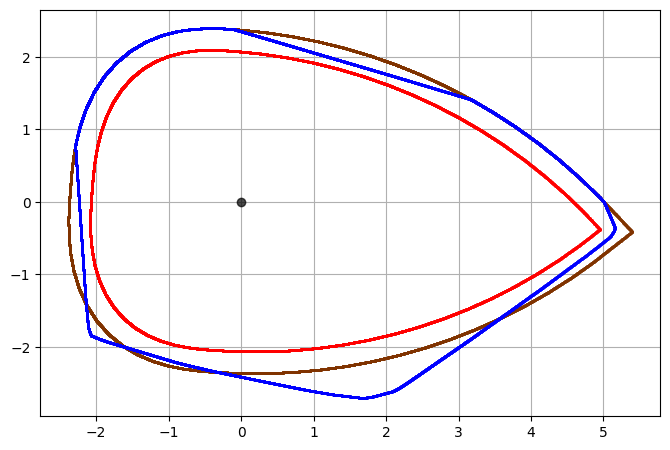

In [358]:
# rough_rotated_pts

j = steps-1
k = i_edge_max-i_edge_min-1
disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))
current_rough_pts = rough_rotated_pts[i_edge_min:i_edge_max] if j == 0 else GetReversed(bruting_traces[j-1])
rough_trace = GetTrace(rough_rotated_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)

rough_rotated_pts = rough_trace

rotation_angle = matan(intersection_pts.geoms[i1])-matan(intersection_pts.geoms[i2])

rough_rotated_pts       = RotateListOfPoints(rough_rotated_pts, -rotation_angle)
pear_rotated_pts        = RotateListOfPoints(pear_rotated_pts,  -rotation_angle)
baloon_pear_rotated_pts = RotateListOfPoints(baloon_pear_rotated_pts, -rotation_angle)

plot_points(pear_rotated_pts, color=(1,0,0), markersize=1, label="target pear")
plot_points(baloon_pear_rotated_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
plot_points(rough_rotated_pts, color=(0,0,1), markersize=1, label="rough pear")
plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

GEOMETRYCOLLECTION (LINESTRING (5.001125465967787 0.003854292291561, 4.998167793291468 0.0069924581010736), LINESTRING (4.998167793291468 0.0069924581010736, 4.995213611700561 0.0101269197803202), LINESTRING (4.995213611700561 0.0101269197803202, 4.992262912689257 0.0132576863541785), LINESTRING (4.992262912689257 0.0132576863541785, 4.989315687777287 0.0163847668204306), LINESTRING (4.989315687777287 0.0163847668204306, 4.9863719285098185 0.0195081701498708), LINESTRING (4.9863719285098185 0.0195081701498708, 4.983431626457353 0.022627905286406), LINESTRING (4.983431626457353 0.022627905286406, 4.980494773215641 0.0257439811471619), LINESTRING (4.980494773215641 0.0257439811471619, 4.977561360405572 0.0288564066225885), LINESTRING (4.977561360405572 0.0288564066225885, 4.974631379673078 0.0319651905765592), LINESTRING (4.974631379673078 0.0319651905765592, 4.971704822689052 0.0350703418464743), LINESTRING (4.971704822689052 0.0350703418464743, 4.968781681149227 0.0381718692433655), LI

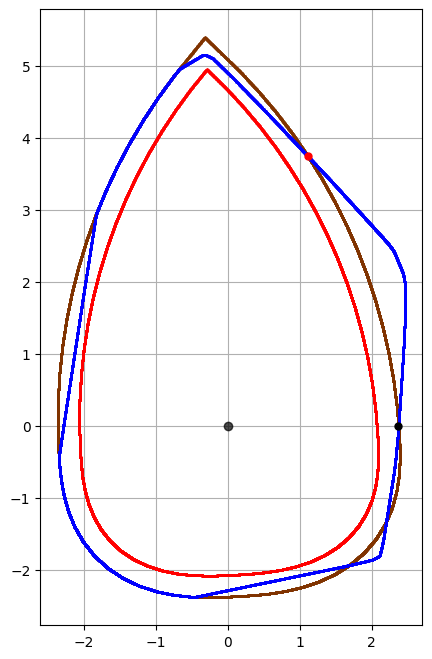

In [330]:
i1, i2 = 7, 0

rough_pts       = rough_rotated_pts
pear_pts        = pear_rotated_pts
baloon_pear_pts = baloon_pear_rotated_pts

intersection = LineString(rough_pts).intersection(LineString(baloon_pear_pts))
print(intersection)
intersection_pts = []
for item in intersection.geoms:
    if item.geom_type == "Point":
        intersection_pts.append(item)
intersection_pts = MultiPoint(intersection_pts)

i_edge_min, i_edge_max = GetEdgeIndices(rough_pts, intersection_pts.geoms[i1], intersection_pts.geoms[i2])
if i_edge_min > i_edge_max: i_edge_min, i_edge_max = Change(i_edge_min, i_edge_max)
print(i_edge_min, i_edge_max)

# plot_points(pear_pts, color=(1,0,0), markersize=1, label="target pear")
# plot_points(baloon_pear_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
# plot_points(rough_pts, color=(0,0,1), markersize=1, label="rough pear")
# plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")
# # plot_points(rough_rotated_pts[i_edge_min], color=(0,0,0), markersize=5, label="min")
# # plot_points(rough_rotated_pts[i_edge_max], color=(0,0,0), markersize=5, label="max")
# plot_points(intersection_pts.geoms[i1], color=(0,0,0), markersize=5, label="min")
# plot_points(intersection_pts.geoms[i2], color=(1,0,0), markersize=5, label="max")

rotation_angle = GetAngleOfRotation(rough_pts, intersection_pts, i1, i2)
rotation_angle = matan(intersection_pts.geoms[i1])

pt_min = rotate(intersection_pts.geoms[i1], -rotation_angle, origin=Point(0.0,0.0), use_radians=True)
pt_max = rotate(intersection_pts.geoms[i2], -rotation_angle, origin=Point(0.0,0.0), use_radians=True)

rough_rotated_pts       = RotateListOfPoints(rough_pts, -rotation_angle)
pear_rotated_pts        = RotateListOfPoints(pear_pts,  -rotation_angle)
baloon_pear_rotated_pts = RotateListOfPoints(baloon_pear_pts, -rotation_angle)

plot_points(pear_rotated_pts, color=(1,0,0), markersize=1, label="target pear")
plot_points(baloon_pear_rotated_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
plot_points(rough_rotated_pts, color=(0,0,1), markersize=1, label="rough pear")
plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")
# plot_points(rough_rotated_pts[i_edge_min], color=(0,0,0), markersize=5, label="min")
# plot_points(rough_rotated_pts[i_edge_max], color=(0,0,0), markersize=5, label="max")
plot_points(pt_min, color=(0,0,0), markersize=5, label="min")
plot_points(pt_max, color=(1,0,0), markersize=5, label="max")

In [331]:
steps = 2

threshold = 10

trace = GetBrutingTrace(rough_rotated_pts[i_edge_min:i_edge_max], baloon_pear_rotated_pts[i_edge_min:i_edge_max], 1, steps, threshold)

bruting_traces = []
disk_traces = []

bruting_traces.append(GetBrutingTrace(rough_rotated_pts[i_edge_min:i_edge_max], baloon_pear_rotated_pts[i_edge_min:i_edge_max], 1, steps, threshold))
disk_traces.append(GetParallelOffset(bruting_traces[-1], 1, R))

for j in range(2, steps+1):
    bruting_traces.append(GetBrutingTrace(bruting_traces[-1], baloon_pear_rotated_pts[i_edge_min:i_edge_max], j, steps, threshold))
    disk_traces.append(GetParallelOffset(bruting_traces[-1], j, R))

pear_rotated = LineString(pear_rotated_pts)
balooned_pear_rotated = LineString(baloon_pear_rotated_pts)
bruting_traces_plgs = []
for j in range(len(bruting_traces)):
    bruting_traces_plgs.append(LineString(bruting_traces[j]))

Smoothing done
Smoothing done
Smoothing done


In [ ]:
# plot_points(rough_rotated_pts, color=(0,0,1), markersize=1, label="rough pear")
plot_points(pear_rotated_pts, color=(1,0,0), markersize=1, label="target pear")
plot_points(baloon_pear_rotated_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")
# plot_points(rough_rotated_pts[i_edge_min], color=(0,0,0), markersize=5, label="min")
# plot_points(rough_rotated_pts[i_edge_max], color=(0,0,0), markersize=5, label="max")

j = steps-1
# k = 500
k = i_edge_max-i_edge_min-1

plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

disk_pts = CreateDisk(R)
disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(disk_pts))
plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4)

plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")

current_rough_pts = rough_rotated_pts[i_edge_min:i_edge_max] if j == 0 else GetReversed(bruting_traces[j-1])
rough_trace = GetTrace(rough_rotated_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
plot_points(rough_trace, color=(0,0,1), markersize=1, label="rough pear")

plt.rcParams["figure.figsize"] = (8.0, 8.0)
# plt.xlim(-0.3, 4.0)
# plt.ylim(-0.5, 3.0)
plt.legend()

In [ ]:
delta = 0.4
r = 2

j = steps-1
i = 0
k = 0
k = i_edge_max-i_edge_min-1
angle = matan(disk_traces[j][k])

xstep = (k/n)*delta*6
xval = R+r-affinity.rotate(disk_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True).x-xstep

plot_points(Point(0.0, 0.0), color=(0,0,0), alpha=0.7, label="absolute center")

plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(pear_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(1,0,0), markersize=0.5, label="target pear")
plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(balooned_pear_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(0.5,0.2,0), markersize=0.5, label="balooned pear")
plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces_plgs[j], -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(0,1,0), markersize=0.5, label="bruting trace")

disk_pts = CreateDisk(R)
disk = transform(lambda x, y, z=None: (x+R+r-xstep, y), Polygon(disk_pts))
plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4, label="bruting disk")

plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(0,1,0), alpha=0.7, label="touch point")

current_rough_pts = rough_rotated_pts[i_edge_min:i_edge_max] if j == 0 else GetReversed(bruting_traces[j-1])

disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(disk_pts))
rough_trace = GetTrace(rough_rotated_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
rotated_rough_trace = RotateListOfPoints(rough_trace, -angle)
transformed_rotated_rough_trace = TransformListOfPoints(rotated_rough_trace, xval, 0)
plot_points(transformed_rotated_rough_trace, color=(0,0,1), markersize=0.5, label="rough pear")

plt.rcParams["figure.figsize"] = (8.0,8.0)
plt.xlim(-6.5, 4)
plt.ylim(-6, 6)
plt.legend()

In [234]:
delta = 0.5
r = 2

path = "swing/general/test3/"

i = 0
for j in range(0, steps):
        for k in tqdm(range(0, i_edge_max-i_edge_min, 20)):
                angle = matan(disk_traces[j][k])

                xstep = (k/n)*delta*6
                xval = R+r-affinity.rotate(disk_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True).x-xstep

                plot_points(Point(0.0, 0.0), color=(0,0,0), alpha=0.7, label="absolute center")

                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(pear_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(1,0,0), markersize=0.5, label="target pear")
                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(balooned_pear_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(0.5,0.2,0), markersize=0.5, label="balooned pear")
                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces_plgs[j], -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(0,1,0), markersize=0.5, label="bruting trace")

                disk_pts = CreateDisk(R)
                disk = transform(lambda x, y, z=None: (x+R+r-xstep, y), Polygon(disk_pts))
                plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4, label="bruting disk")

                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(0,1,0), alpha=0.7, label="touch point")

                current_rough_pts = rough_rotated_pts[i_edge_min:i_edge_max] if j == 0 else GetReversed(bruting_traces[j-1])

                disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(disk_pts))
                rough_trace = GetTrace(rough_rotated_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
                rotated_rough_trace = RotateListOfPoints(rough_trace, -angle)
                transformed_rotated_rough_trace = TransformListOfPoints(rotated_rough_trace, xval, 0)
                plot_points(transformed_rotated_rough_trace, color=(0,0,1), markersize=0.5, label="rough pear")

                plt.rcParams["figure.figsize"] = (8.0,8.0)
                plt.xlim(-6.5, 4)
                plt.ylim(-6, 3)
                plt.legend()
                plt.savefig(path+"pics/" + str(i) + ".png")
                plt.close()
                i += 1

with imageio.get_writer(path+'movie.gif', mode='I', duration=0.01) as writer:
    for j in range(i):
        writer.append_data(imageio.imread(path+"pics/" + str(j) + ".png"))

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

C:\Users\konov\AppData\Local\Temp\ipykernel_16220\2242049694.py:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(path+"pics/" + str(j) + ".png"))


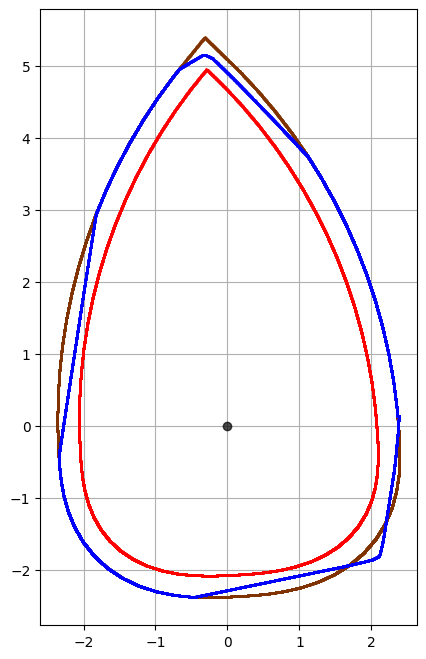

In [332]:
# rough_rotated_pts

j = steps-1
k = i_edge_max-i_edge_min-1
disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))
current_rough_pts = rough_rotated_pts[i_edge_min:i_edge_max] if j == 0 else GetReversed(bruting_traces[j-1])
rough_trace = GetTrace(rough_rotated_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)

rough_rotated_pts = rough_trace

plot_points(pear_rotated_pts, color=(1,0,0), markersize=1, label="target pear")
plot_points(baloon_pear_rotated_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
plot_points(rough_rotated_pts, color=(0,0,1), markersize=1, label="rough pear")
plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

GEOMETRYCOLLECTION (LINESTRING (1.1198298794523653 3.737913034157153, 1.1215566247254634 3.7351384500739853), LINESTRING (1.1215566247254634 3.7351384500739853, 1.123281458668254 3.732366937171454), LINESTRING (1.123281458668254 3.732366937171454, 1.1250043858120664 3.7295984881684907), LINESTRING (1.1250043858120664 3.7295984881684907, 1.126725410675213 3.7268330958049405), LINESTRING (1.126725410675213 3.7268330958049405, 1.1284445377630297 3.724070752841498), LINESTRING (1.1284445377630297 3.724070752841498, 1.1301617715679313 3.7213114520596227), LINESTRING (1.1301617715679313 3.7213114520596227, 1.1318771165694557 3.718555186261465), LINESTRING (1.1318771165694557 3.718555186261465, 1.1335905772343111 3.715801948269788), LINESTRING (1.1335905772343111 3.715801948269788, 1.135302158016428 3.7130517309278877), LINESTRING (1.135302158016428 3.7130517309278877, 1.137011863357001 3.7103045270995247), LINESTRING (1.137011863357001 3.7103045270995247, 1.1387196976845408 3.707560329668842

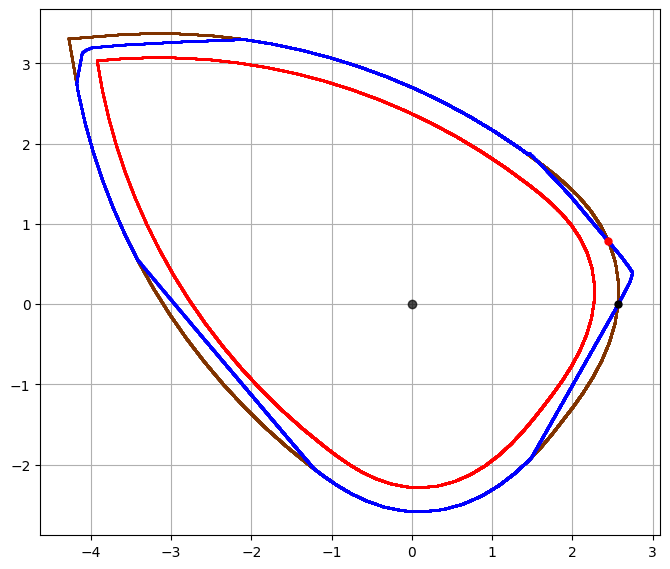

In [333]:
i1, i2 = 0, 7

rough_pts       = rough_rotated_pts
pear_pts        = pear_rotated_pts
baloon_pear_pts = baloon_pear_rotated_pts

intersection = LineString(rough_pts).intersection(LineString(baloon_pear_pts))
print(intersection)
intersection_pts = []
for item in intersection.geoms:
    if item.geom_type == "Point":
        intersection_pts.append(item)
intersection_pts = MultiPoint(intersection_pts)

i_edge_min, i_edge_max = GetEdgeIndices(rough_pts, intersection_pts.geoms[i1], intersection_pts.geoms[i2])
if i_edge_min > i_edge_max: i_edge_min, i_edge_max = Change(i_edge_min, i_edge_max)
print(i_edge_min, i_edge_max)

# plot_points(pear_pts, color=(1,0,0), markersize=1, label="target pear")
# plot_points(baloon_pear_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
# plot_points(rough_pts, color=(0,0,1), markersize=1, label="rough pear")
# plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")
# # plot_points(rough_rotated_pts[i_edge_min], color=(0,0,0), markersize=5, label="min")
# # plot_points(rough_rotated_pts[i_edge_max], color=(0,0,0), markersize=5, label="max")
# plot_points(intersection_pts.geoms[i1], color=(0,0,0), markersize=5, label="min")
# plot_points(intersection_pts.geoms[i2], color=(1,0,0), markersize=5, label="max")

rotation_angle = GetAngleOfRotation(rough_pts, intersection_pts, i1, i2)
rotation_angle = matan(intersection_pts.geoms[i1])

pt_min = rotate(intersection_pts.geoms[i1], -rotation_angle, origin=Point(0.0,0.0), use_radians=True)
pt_max = rotate(intersection_pts.geoms[i2], -rotation_angle, origin=Point(0.0,0.0), use_radians=True)

rough_rotated_pts       = RotateListOfPoints(rough_pts, -rotation_angle)
pear_rotated_pts        = RotateListOfPoints(pear_pts,  -rotation_angle)
baloon_pear_rotated_pts = RotateListOfPoints(baloon_pear_pts, -rotation_angle)

plot_points(pear_rotated_pts, color=(1,0,0), markersize=1, label="target pear")
plot_points(baloon_pear_rotated_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
plot_points(rough_rotated_pts, color=(0,0,1), markersize=1, label="rough pear")
plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")
# plot_points(rough_rotated_pts[i_edge_min], color=(0,0,0), markersize=5, label="min")
# plot_points(rough_rotated_pts[i_edge_max], color=(0,0,0), markersize=5, label="max")
plot_points(pt_min, color=(0,0,0), markersize=5, label="min")
plot_points(pt_max, color=(1,0,0), markersize=5, label="max")

In [334]:
steps = 1

threshold = 10

trace = GetBrutingTrace(rough_rotated_pts[i_edge_min:i_edge_max], baloon_pear_rotated_pts[i_edge_min:i_edge_max], 1, steps, threshold)

bruting_traces = []
disk_traces = []

bruting_traces.append(GetBrutingTrace(rough_rotated_pts[i_edge_min:i_edge_max], baloon_pear_rotated_pts[i_edge_min:i_edge_max], 1, steps, threshold))
disk_traces.append(GetParallelOffset(bruting_traces[-1], 1, R))

for j in range(2, steps+1):
    bruting_traces.append(GetBrutingTrace(bruting_traces[-1], baloon_pear_rotated_pts[i_edge_min:i_edge_max], j, steps, threshold))
    disk_traces.append(GetParallelOffset(bruting_traces[-1], j, R))

pear_rotated = LineString(pear_rotated_pts)
balooned_pear_rotated = LineString(baloon_pear_rotated_pts)
bruting_traces_plgs = []
for j in range(len(bruting_traces)):
    bruting_traces_plgs.append(LineString(bruting_traces[j]))

Smoothing done
Smoothing done


In [ ]:
# plot_points(rough_rotated_pts, color=(0,0,1), markersize=1, label="rough pear")
plot_points(pear_rotated_pts, color=(1,0,0), markersize=1, label="target pear")
plot_points(baloon_pear_rotated_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")
# plot_points(rough_rotated_pts[i_edge_min], color=(0,0,0), markersize=5, label="min")
# plot_points(rough_rotated_pts[i_edge_max], color=(0,0,0), markersize=5, label="max")

j = steps-1
# k = 500
k = i_edge_max-i_edge_min-1

plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

disk_pts = CreateDisk(R)
disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(disk_pts))
plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4)

plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")

current_rough_pts = rough_rotated_pts[i_edge_min:i_edge_max] if j == 0 else GetReversed(bruting_traces[j-1])
rough_trace = GetTrace(rough_rotated_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
plot_points(rough_trace, color=(0,0,1), markersize=1, label="rough pear")

plt.rcParams["figure.figsize"] = (8.0, 8.0)
# plt.xlim(-0.3, 4.0)
# plt.ylim(-0.5, 3.0)
plt.legend()

In [ ]:
delta = 0.4
r = 2

j = steps-1
i = 0
k = 0
k = i_edge_max-i_edge_min-1
angle = matan(disk_traces[j][k])

xstep = (k/n)*delta*6
xval = R+r-affinity.rotate(disk_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True).x-xstep

plot_points(Point(0.0, 0.0), color=(0,0,0), alpha=0.7, label="absolute center")

plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(pear_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(1,0,0), markersize=0.5, label="target pear")
plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(balooned_pear_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(0.5,0.2,0), markersize=0.5, label="balooned pear")
plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces_plgs[j], -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(0,1,0), markersize=0.5, label="bruting trace")

disk_pts = CreateDisk(R)
disk = transform(lambda x, y, z=None: (x+R+r-xstep, y), Polygon(disk_pts))
plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4, label="bruting disk")

plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True)), 
        color=(0,1,0), alpha=0.7, label="touch point")

current_rough_pts = rough_rotated_pts[i_edge_min:i_edge_max] if j == 0 else GetReversed(bruting_traces[j-1])

disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(disk_pts))
rough_trace = GetTrace(rough_rotated_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
rotated_rough_trace = RotateListOfPoints(rough_trace, -angle)
transformed_rotated_rough_trace = TransformListOfPoints(rotated_rough_trace, xval, 0)
plot_points(transformed_rotated_rough_trace, color=(0,0,1), markersize=0.5, label="rough pear")

plt.rcParams["figure.figsize"] = (8.0,8.0)
plt.xlim(-6.5, 4)
plt.ylim(-6, 6)
plt.legend()

In [243]:
delta = 0.5
r = 2

path = "swing/general/test4/"

i = 0
for j in range(0, steps):
        for k in tqdm(range(0, i_edge_max-i_edge_min, 20)):
                angle = matan(disk_traces[j][k])

                xstep = (k/n)*delta*6
                xval = R+r-affinity.rotate(disk_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True).x-xstep

                plot_points(Point(0.0, 0.0), color=(0,0,0), alpha=0.7, label="absolute center")

                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(pear_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(1,0,0), markersize=0.5, label="target pear")
                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(balooned_pear_rotated, -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(0.5,0.2,0), markersize=0.5, label="balooned pear")
                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces_plgs[j], -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(0,1,0), markersize=0.5, label="bruting trace")

                disk_pts = CreateDisk(R)
                disk = transform(lambda x, y, z=None: (x+R+r-xstep, y), Polygon(disk_pts))
                plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4, label="bruting disk")

                plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True)), 
                        color=(0,1,0), alpha=0.7, label="touch point")

                current_rough_pts = rough_rotated_pts[i_edge_min:i_edge_max] if j == 0 else GetReversed(bruting_traces[j-1])

                disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(disk_pts))
                rough_trace = GetTrace(rough_rotated_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
                rotated_rough_trace = RotateListOfPoints(rough_trace, -angle)
                transformed_rotated_rough_trace = TransformListOfPoints(rotated_rough_trace, xval, 0)
                plot_points(transformed_rotated_rough_trace, color=(0,0,1), markersize=0.5, label="rough pear")

                plt.rcParams["figure.figsize"] = (8.0,8.0)
                plt.xlim(-6.5, 4)
                plt.ylim(-6, 6)
                plt.legend()
                plt.savefig(path+"pics/" + str(i) + ".png")
                plt.close()
                i += 1

with imageio.get_writer(path+'movie.gif', mode='I', duration=0.01) as writer:
    for j in range(i):
        writer.append_data(imageio.imread(path+"pics/" + str(j) + ".png"))

  0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\konov\AppData\Local\Temp\ipykernel_16220\4195300049.py:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(path+"pics/" + str(j) + ".png"))


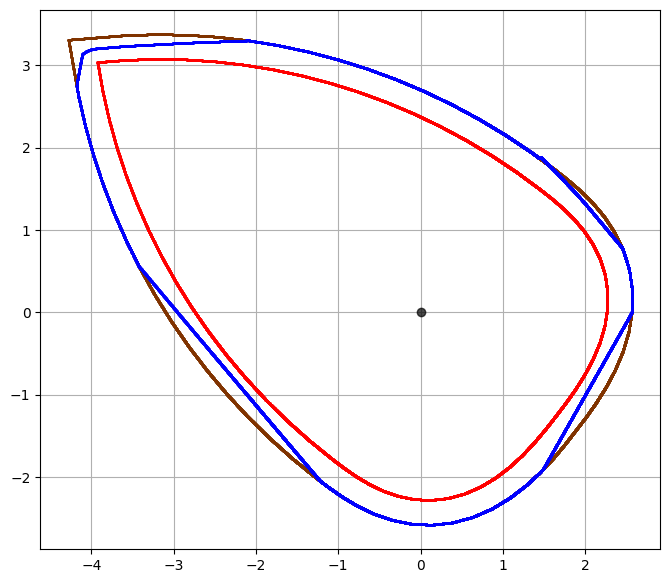

In [335]:
# rough_rotated_pts

j = steps-1
k = i_edge_max-i_edge_min-1
disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))
current_rough_pts = rough_rotated_pts[i_edge_min:i_edge_max] if j == 0 else GetReversed(bruting_traces[j-1])
rough_trace = GetTrace(rough_rotated_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)

rough_rotated_pts = rough_trace

plot_points(pear_rotated_pts, color=(1,0,0), markersize=1, label="target pear")
plot_points(baloon_pear_rotated_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
plot_points(rough_rotated_pts, color=(0,0,1), markersize=1, label="rough pear")
plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

In [340]:
def GetMinDistantIndex(pts1, pts2):
    i_min, dst_min = 0, pts1[0].distance(pts2[0])
    for i in range(1, len(pts1)):
        dst = pts1[i].distance(pts2[i])
        if dst < dst_min:
            i_min, dst_min = i, dst
    return i_min

def SmoothContour(pts, threshold):
    indices = GetCornerIndices(pts, threshold)

    while len(indices) != 0:
        # print(len(indices))
        smoothed_pts = []
        for i in range(len(pts)):
            if i not in indices:
                smoothed_pts.append(pts[i])
            else:
                pt1 = pts[i-1]
                pt2 = pts[i+1]
                pt = pts[i]
                nrm = norma(pt)
                coeff = (norma(pt1)+norma(pt2))/2
                smoothed_pts.append(Point(coeff*pt.x/nrm, coeff*pt.y/nrm))

        pts = smoothed_pts
        # mean = GetAverageCurvature(bruting_rough_trace_pts)
        indices = GetCornerIndices(pts, threshold)

    print("Smoothing done")
    return smoothed_pts

def GetParallelOffsetRing(bruting_trace_pts, R):
    normal_vectors = []
    for i in range(len(bruting_trace_pts)-1):
        pt1, pt2 = bruting_trace_pts[i], bruting_trace_pts[i+1]
        x1, y1 = pt1.x, pt1.y
        x2, y2 = pt2.x, pt2.y
        nrm = sqrt((x2-x1)**2+(y2-y1)**2)
        normal_vectors.append(Point(R*(y2-y1)/nrm, -R*(x2-x1)/nrm))
    
    normal_vertices = []
    x = (normal_vectors[-1].x+normal_vectors[0].x)/2
    y = (normal_vectors[-1].y+normal_vectors[0].y)/2
    normal_vertices.append(Point(x, y))
    for i in range(len(normal_vectors)-1):
        x = (normal_vectors[i].x+normal_vectors[i+1].x)/2
        y = (normal_vectors[i].y+normal_vectors[i+1].y)/2
        normal_vertices.append(Point(x, y))
    x = (normal_vectors[-1].x+normal_vectors[0].x)/2
    y = (normal_vectors[-1].y+normal_vectors[0].y)/2
    normal_vertices.append(Point(x, y))

    # print(len(bruting_trace_pts), len(normal_vectors), len(normal_vertices))

    disk_trace_pts = []
    for i in range(len(bruting_trace_pts)):
        x = bruting_trace_pts[i].x+normal_vertices[i].x
        y = bruting_trace_pts[i].y+normal_vertices[i].y
        disk_trace_pts.append(Point(x, y))

    # return list(MultiPoint(LineString(bruting_trace_pts).parallel_offset(R, 'right', join_style=1).coords).geoms)
    return disk_trace_pts


def rotateArray(array):
    array[:] = array[-1:]+array[:-1]

In [321]:
def GetRingTrace(rough_pts, target_pts, disk_trace_pts, disk, R, j, k):
    rough_string = LinearRing(rough_pts)
    npts = rough_string.intersection(disk)
    print(npts)

    anglec = matan(disk_trace_pts[k])
    rc = norma(disk_trace_pts[k])

    trace = []
    if npts.geom_type == 'LineString':
        if len(npts.coords) != 0:
            angle_edge = atan2(npts.coords[-1][1], npts.coords[-1][0])
            if angle_edge <= 0: angle_edge += 2*pi
            print(angle_edge*180/pi)

            for i in range(1, len(rough_pts)):
                # print(matan(rough_pts[i]))
                if matan(rough_pts[i]) >= angle_edge:
                    i_intersect = i
                    break
            print(i_intersect)

            for i in (range(len(rough_pts))):
                if i < k:
                    trace.append(target_pts[i])
                elif k <= i and i < i_intersect:
                    angle_cur = matan(rough_pts[i])
                    
                    lr = rc*cos(angle_cur-anglec)-sqrt(R**2-(rc*sin(angle_cur-anglec))**2)
                    trace.append(Point(lr*cos(angle_cur), lr*sin(angle_cur)))
                else:
                    trace.append(rough_pts[i])
        else:
            for i in (range(len(rough_pts))):
                if i < k:
                    trace.append(target_pts[i])
                else:
                    trace.append(rough_pts[i])
    else:
        if len(npts.geoms[0].coords) != 0:

            angle_edge = atan2(npts.geoms[0].coords[-1][1], npts.geoms[0].coords[-1][0])
            if angle_edge <= 0:
                angle_edge += 2*pi

            for i in range(1, len(rough_pts)):
                if matan(rough_pts[i]) >= angle_edge:
                    i_intersect = i
                    break

            for i in (range(len(rough_pts))):
                if i < k:
                    trace.append(target_pts[i])
                elif k <= i and i < i_intersect:
                    angle_cur = matan(rough_pts[i])
                        
                    lr = rc*cos(angle_cur-anglec)-sqrt(R**2-(rc*sin(angle_cur-anglec))**2)
                    trace.append(Point(lr*cos(angle_cur), lr*sin(angle_cur)))
                else:
                    trace.append(rough_pts[i])
        else:
            for i in (range(len(rough_pts))):
                if i < k:
                    trace.append(target_pts[i])
                else:
                    trace.append(rough_pts[i])
        
    return trace

In [364]:
i_dist_min = GetMinDistantIndex(rough_rotated_pts, pear_rotated_pts)
rotation_angle = matan(rough_rotated_pts[i_dist_min])

rough_pts       = RotateListOfPoints(rough_rotated_pts, -rotation_angle)
pear_pts        = RotateListOfPoints(pear_rotated_pts, -rotation_angle)
baloon_pear_pts = RotateListOfPoints(baloon_pear_rotated_pts, -rotation_angle)

for i in range(i_dist_min):
    rotateArray(rough_pts)
    rotateArray(pear_pts)
    rotateArray(baloon_pear_pts)

balood_coeff = rough_pts[0].distance(pear_pts[0])
threshold = 10
bruting_traces = []
disk_traces = []

bruting_traces.append(SmoothContour(Contour2Points(LinearRing(LineString(pear_pts).parallel_offset(balood_coeff, 'right', join_style=1)), n), threshold))
disk_traces.append(GetParallelOffsetRing(bruting_traces[0], R))

C:\Users\konov\AppData\Local\Temp\ipykernel_16220\3188788010.py:36: RuntimeWarning: divide by zero encountered in divide
  normal = np.array([1/length_dT_dt]).transpose() * dT_dt
C:\Users\konov\AppData\Local\Temp\ipykernel_16220\3188788010.py:36: RuntimeWarning: invalid value encountered in multiply
  normal = np.array([1/length_dT_dt]).transpose() * dT_dt


Smoothing done


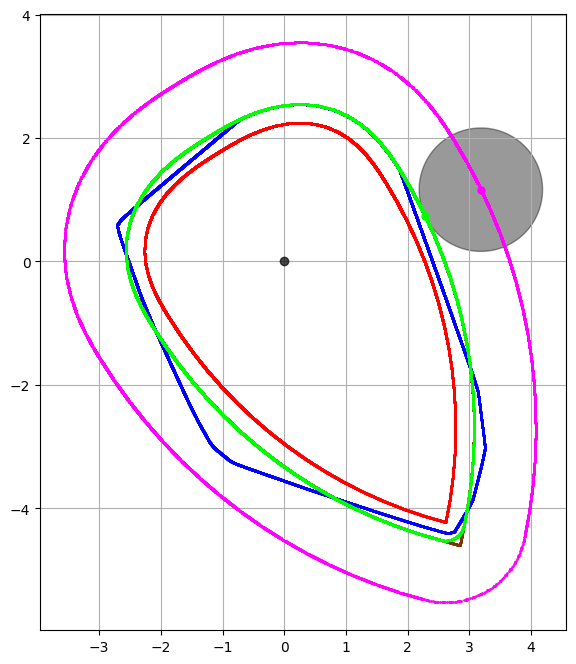

In [365]:
plot_points(pear_pts, color=(1,0,0), markersize=1, label="target pear")
plot_points(baloon_pear_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
plot_points(rough_pts, color=(0,0,1), markersize=1, label="rough pear")
plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

# plot_points(rough_rotated_pts[i_dist_min], color=(0,0,0), markersize=5, label="min dist")

j = 0
k = 500

plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

disk_pts = CreateDisk(R)
disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(disk_pts))
plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4)

plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")
plot_points(disk_traces[j][k], color=(1,0,1), markersize=5, label="center of disk")
# plot_points(rough_pts[k], color=(0,0,1), markersize=5, label="rough pear point")

# current_rough_pts = rough_pts if j == 0 else bruting_traces[j-1]
# rough_trace = GetRingTrace(current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
# plot_points(rough_trace, color=(0,0,1), markersize=1, label="rough pear")

plt.rcParams["figure.figsize"] = (8.0, 8.0)
# plt.xlim(-0.3, 4.0)
# plt.ylim(-0.5, 3.0)
# plt.legend()